In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch as torch
import pywt
from scipy.signal import welch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from xgboost import XGBClassifier

import numpy as np
import pywt
from scipy.signal import welch
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

class EEGUtil:
    @staticmethod
    def load_data(file_path, column_names=['spike hz']):
        """Load multi-channel EEG data from a CSV file and normalize it.

        Parameters:
        - file_path: Path to the CSV file.
        - column_names: List of EEG signal column names to load.

        Returns:
        - signal: 2D numpy array (channels × time), normalized.
        """
        data = pd.read_csv(file_path)

        # 确保所有列都存在
        available_columns = [col for col in column_names if col in data.columns]
        if not available_columns:
            raise ValueError(f"None of the specified columns {column_names} exist in {file_path}")

        signal = data[available_columns].values.T  # (channels, time)

        # **🔥 强制 z-score 归一化**
        mean = np.mean(signal, axis=1, keepdims=True)
        std = np.std(signal, axis=1, keepdims=True)

        # 防止标准差为 0，避免 NaN
        std[std == 0] = 1e-8  
        
        #signal = (signal - mean) / std  # 归一化
        
        return signal

    @staticmethod
    def padding(signal, target_length, mode="constant", constant_value=0):
        """Pad or truncate multi-channel signal to the target length."""
        signal = np.array(signal)  # Ensure it's a NumPy array
        channels, current_length = signal.shape
        
        if current_length >= target_length:
            return signal[:, :target_length]  # Truncate

        padding_size = target_length - current_length
        if mode == "constant":
            pad_values = np.full((channels, padding_size), constant_value)
        elif mode == "reflect":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='reflect')[:, -padding_size:]
        elif mode == "cyclic":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='wrap')[:, -padding_size:]
        elif mode == "edge":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='edge')[:, -padding_size:]
        elif mode == "random":
            pad_values = np.random.uniform(low=np.min(signal), high=np.max(signal), size=(channels, padding_size))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

        return np.hstack((signal, pad_values))  # Concatenate along time axis
    
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

class EEGDataset(Dataset):
    def __init__(self, data_folder, outcome_file=None, ssd_file=None,start_time=16,target_length=600, strategy='padding', 
                 padding_mode="constant", use_labels=False, augment=False,num_good=1,num_bad=1,column_names=['spike hz']):
        
        """
        EEG signal datasets with support for data enhancement (random fill). 

        Parameters: 
        - data_folder: path of the EEG data folder 
        - outcome_file: CSV file with patient ID and outcome (optional) 
        - target_length: indicates the padding length of the target 
        - strategy: wavelet ('padding', 'wavelet', 'psd') 
        - padding_mode: indicates the fill mode ('constant', 'reflect',...). 
        - use_labels: indicates whether to use labels 
        - augment: Whether data enhancement is enabled (randomly fill different lengths) 
        """

        self.use_labels = use_labels
        self.data_folder = data_folder
        self.target_length = target_length
        self.strategy = strategy
        self.padding_mode = padding_mode
        self.augment = augment # 是否启用数据增强
        self.column_names = column_names #Feature Chosen
        
        self.num_good = num_good
        self.num_bad = num_bad
        
        self.start_time=16
        self.end_time=int((target_length/12)+self.start_time)

        self.file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
       
        # Read 'rosc sec' start time
        ssd_df = pd.read_csv(ssd_file)
        # Get `pat_ID`
        ssd_df["pat_ID"] = ssd_df["fn"].str.extract(r"(ICARE_\d+)")
        #  Take the smallest 'rosc sec' of each 'pat ID' 
        self.rosc_dict = ssd_df.groupby("pat_ID")["rosc_sec"].min().to_dict()
        
        # LOAD Labels
        self.outcome_dict = {}
        if use_labels and outcome_file:
            self.outcome_data = pd.read_csv(outcome_file)
            self.outcome_dict = self.outcome_data.set_index('pat_ID')['outcome'].to_dict()
            self.file_list = [f for f in self.file_list if f.split('.')[0] in self.outcome_dict]
        
        self.valid_files = []
        # Filter EEG data conforming to 16h-68h rules
        for f in self.file_list:
            pat_id = f.split('.')[0]

            if pat_id in self.rosc_dict:
                file_path = os.path.join(self.data_folder, f)
                signal = EEGUtil.load_data(file_path, column_names=self.column_names)  #Load Multiple Channel
                rosc_sec = float(self.rosc_dict[pat_id])  # Ensure `rosc_sec` is a float

                # **EEG recording time range**
                start_time = rosc_sec
                end_time = start_time + signal.shape[1] * 300  # Each point represents 5 minutes (=300 seconds)
                # **Skip if the data is completely outside the 16h-68h observation window**
                if end_time < self.start_time * 3600 or start_time > self.end_time * 3600:
                    #print(f"❌ Skipping {pat_id}: EEG data is out of 16h-68h range ({start_time/3600:.1f}h - {end_time/3600:.1f}h)")
                    continue  

                # **Align to the 16h-68h window**
                aligned_signal = self.align_signal(signal, rosc_sec)
                self.valid_files.append((f, aligned_signal))

        #print(f"✅ Loaded {len(self.valid_files)} valid EEG files (filtered from {len(self.file_list)} total)")

        # **Count Good/Bad Outcome samples**
        self.good_outcome_count = sum(1 for f, _ in self.valid_files if self.get_label(f.split('.')[0]) == 1)
        self.bad_outcome_count = len(self.valid_files) - self.good_outcome_count

        #print(f"Good Outcome: {self.good_outcome_count}, Bad Outcome: {self.bad_outcome_count}")

        # **Data Augmentation: Expanding indices**
        self.expanded_indices = []
        for idx, (filename, signal) in enumerate(self.valid_files):
            patient_id = filename.split('.')[0]
            label = self.get_label(patient_id) if self.use_labels else -1

            if self.augment:
                if self.use_labels:
                    # Good Outcome ×10, Bad Outcome ×2
                    if label == 1:
                        repeat_times = self.num_good
                    else:
                        repeat_times = self.num_bad
                else:
                    repeat_times = 1  # Data augmentation for unlabeled data
            else:
                repeat_times = 1  

            for _ in range(repeat_times):
                self.expanded_indices.append((idx, label))  # ✅ Store index & label
    
    def __len__(self):
        # print(f"📏 Dataset __len__: {len(self.expanded_indices)}")  # Ensure `expanded_indices` length is correct
        return len(self.expanded_indices)  # ✅ Must return the number of samples after data augmentation
    
    def __getitem__(self, idx):
        original_idx, label = self.expanded_indices[idx]
        filename, signal = self.valid_files[original_idx]  # Directly retrieve the **aligned** signal
        patient_id = filename.split('.')[0]

        # Get label
        label = -1
        if self.use_labels:
            label = self.get_label(patient_id)

        # Perform data augmentation (varies each time)
        if self.augment:
            augmented_signal = self.augment_signal(signal)  # ✅ Apply augmentation directly to the **aligned signal**
        else:
            augmented_signal = signal  # ✅ Use the aligned signal directly

        return torch.tensor(augmented_signal, dtype=torch.float32), label
    
    def align_signal(self, signal, rosc_sec):
        """ Align EEG data to the 16h-68h observation period """

        target_length = self.target_length  # Number of `5min` windows for 52 hours (624)
        total_signal_length = signal.shape[1]  # Total length of the EEG recording
        
        rosc_sec = float(rosc_sec)  # ✅ Ensure `rosc_sec` is a float
        # print(f"🔍 Processing patient data: rosc_sec={rosc_sec}, total_signal_length={total_signal_length}")

        # **Calculate the starting position of '16h' in the EEG recording**
        start_sec = (self.start_time * 3600) - rosc_sec  
        if start_sec < 0:
            pad_size = abs(start_sec) / 300  # Calculate the number of windows to pad
            start_index = 0  # Start extracting data from the beginning of the EEG recording
        else:
            pad_size = 0  # No padding needed
            start_index = int(start_sec // 300)  # ✅ Convert to integer

        # **Calculate the endpoint index for '68h'**
        end_index = int(min(start_index + target_length, total_signal_length))  # ✅ Convert to integer

        # **Extract EEG data for the 16h-68h observation period**
        aligned_signal = signal[:, start_index:end_index]

        # **Pre-padding (if `rosc_sec > 16h`)**
        if pad_size > 0:
            aligned_signal = EEGDataset.pad_signal(aligned_signal, target_length, self.padding_mode, padding_position="pre")

        # **Post-padding (if data is less than 52 hours)**
        aligned_signal = EEGDataset.pad_signal(aligned_signal, target_length, self.padding_mode, padding_position="post")

        # print(f"✅ Aligned signal length: {len(aligned_signal)}")
        return aligned_signal
    
    def pad_signal(signal, target_length, mode="constant", constant_value=0, padding_position="post"):
        """ Pad EEG signal to ensure it reaches `target_length`.

        Parameters:
        - signal: Original EEG signal (numpy array)
        - target_length: Target length (52h = 624 `5min` windows)
        - mode: Padding mode:
            - `constant`: Fill with a fixed value (`constant_value`)
            - `reflect`: Mirror padding
            - `cyclic`: Cyclic padding
            - `edge`: Edge padding
            - `random`: Fill with random values between [min, max]
        - padding_position: `"pre"` (pad at the beginning) or `"post"` (pad at the end)

        Returns:
        - Padded EEG signal (numpy array)
        """

        channels, current_length = signal.shape
        
        if current_length >= target_length:
            return signal[:, :target_length]  # Truncate if already long enough

        padding_size = target_length - current_length  # Number of elements to pad

        if mode == "constant":
            pad_values = np.full((channels, padding_size), constant_value)  # Make sure padding shape matches
        elif mode == "reflect":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='reflect')[:, -padding_size:]
        elif mode == "cyclic":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='wrap')[:, -padding_size:]
        elif mode == "edge":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='edge')[:, -padding_size:]
        elif mode == "random":
            pad_values = np.random.uniform(low=np.min(signal), high=np.max(signal), size=(channels, padding_size))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

        # Ensure proper concatenation along the time axis
        if padding_position == "pre":
            padded_signal = np.hstack((pad_values, signal))  # Pad at the beginning
        else:
            padded_signal = np.hstack((signal, pad_values))  # Pad at the end

        return padded_signal[:, :target_length]  # Ensure exact target length
    
    def augment_signal(self, signal):
        """ Data augmentation: Shift EEG data within the 16h-68h observation period """

        target_length = self.target_length  # Number of `5min` windows for 52 hours (624)
        channels, current_length = signal.shape  # Current EEG recording length

        # **Check if already aligned to 16h-68h before augmentation**
        if current_length != target_length:
            raise ValueError(f"Before augmentation, signal length should be {target_length}, but received {current_length}")

        # **Augmentation Strategy 1: Random time shift within ±60min**
        max_shift = 12  # `5min` windows, 60 minutes = 12 data points
        shift = np.random.randint(-max_shift, max_shift + 1)  # Random shift in [-12, 12]

        # **Compute new starting index and ensure it remains within bounds**
        start_index = max(0, min(current_length - target_length, shift))
        end_index = min(start_index + target_length, current_length)

        # **Extract EEG data after shifting**
        augmented_signal = signal[:, start_index:end_index]

        # **Augmentation Strategy 2: Apply padding based on `shift` direction**
        if augmented_signal.shape[1] < target_length:
            padding_size = target_length - augmented_signal.shape[1]

            if shift > 0:
                # **向右平移: 在前面填充**
                pad_values = self.pad_signal(np.zeros((channels, padding_size)), target_length, self.padding_mode)
                augmented_signal = np.hstack((pad_values, augmented_signal))  # **确保形状正确**
            elif shift < 0:
                # **向左平移: 在后面填充**
                pad_values = self.pad_signal(np.zeros((channels, padding_size)), target_length, self.padding_mode)
                augmented_signal = np.hstack((augmented_signal, pad_values))
            else:
                # **不平移，直接填充**
                augmented_signal = self.pad_signal(augmented_signal, target_length, self.padding_mode)

        return augmented_signal

    def get_label(self, patient_id):
        """ Get sample label (1 = Good Outcome, 0 = Bad Outcome) """
        return 1 if self.outcome_dict.get(patient_id, 'Bad Outcome') == 'Good Outcome' else 0

    def compare_data_augmentation(self):
        """ Compare the number of samples before and after data augmentation. """
        original_count = len(self.valid_files)  # Count only files that meet the 16h condition
        augmented_count = len(self.expanded_indices)  # Count the number of augmented samples

        print(f"Data count before augmentation: {original_count}")
        print(f"Data count after augmentation: {augmented_count}")
        print(f"Augmentation ratio: {augmented_count / original_count:.2f}x")

        if self.use_labels:
            # Count Good Outcome and Bad Outcome samples in original data (filtered_files)
            good_outcome_original = sum(1 for f, _ in self.valid_files if self.get_label(f.split('.')[0]) == 1)
            bad_outcome_original = original_count - good_outcome_original  # Remaining are Bad Outcome samples

            # Count Good Outcome and Bad Outcome samples after augmentation
            good_outcome_augmented = sum(
                1 for (idx, _) in self.expanded_indices  # ✅ Use only idx, ignore label
                if self.get_label(self.valid_files[idx][0].split('.')[0]) == 1
            )
            bad_outcome_augmented = augmented_count - good_outcome_augmented  # Remaining are Bad Outcome samples

            print(f"Good Outcome before augmentation: {good_outcome_original}, after augmentation: {good_outcome_augmented}")
            print(f"Bad Outcome before augmentation: {bad_outcome_original}, after augmentation: {bad_outcome_augmented}")

        return original_count, augmented_count
    
# AugmentedEEGDataset (适配多通道)
class AugmentedEEGDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, eeg_dataset_instance, augment=True, num_good=10, num_bad=2):
        self.base_dataset = base_dataset
        self.eeg_dataset_instance = eeg_dataset_instance  # 保存实例
        self.augment = augment
        self.num_good = num_good
        self.num_bad = num_bad
        self.expanded_data = []

        for i in range(len(base_dataset)):
            signal, label = base_dataset[i]
            repeat = num_good if label == 1 else num_bad  # 按类别决定增强比例

            for _ in range(repeat):
                # **🔥 兼容多通道数据**
                signal_np = signal.numpy()
                if signal_np.ndim == 2:
                    augmented_signal = self.eeg_dataset_instance.augment_signal(signal_np)
                else:
                    augmented_signal = self.eeg_dataset_instance.augment_signal(signal_np[np.newaxis, :])  # **单通道兼容**

                self.expanded_data.append((augmented_signal, label))

    def __len__(self):
        return len(self.expanded_data)

    def __getitem__(self, idx):
        signal, label = self.expanded_data[idx]
        return torch.tensor(signal, dtype=torch.float32), label
# 统计类别信息
def count_labels(dataset):
    labels = [dataset[i][1] for i in range(len(dataset))]  # 取出所有样本的 label
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))

initial_channels = 128
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNEncoder, self).__init__()

        layers = [
            nn.Conv1d(1, initial_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        ]

        in_channels = initial_channels
        for _ in range(3):
            out_channels = in_channels // 2
            layers.extend([
                nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)
        self.flatten_dim = in_channels * seq_length
        self.fc_mean = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # 拉平
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar


class CNNDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, initial_channels // 8 * seq_length)

        layers = [nn.LeakyReLU()]
        in_channels = initial_channels // 8
        for _ in range(3):
            out_channels = in_channels * 2
            layers.extend([
                nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels
        
        layers.pop()
        layers.append(nn.ConvTranspose1d(in_channels, 1, kernel_size=3, stride=1, padding=1))

        self.decoder = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), initial_channels // 8, seq_length)
        x = self.decoder(x)
        return F.leaky_relu(x)


class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = CNNEncoder(latent_dim)
        self.decoder = CNNDecoder(latent_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        reconstruction = self.decoder(z)
        return reconstruction, mean, logvar
    
    def get_embedding(self, x):
        """ 提取 `latent feature` """
        self.eval()
        with torch.no_grad():
            mean, logvar = self.encoder(x)
            z = self.reparameterize(mean, logvar)  # ✅ 这里返回 `z` 作为 `latent feature`
        return z

# ✅ 计算模型参数
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


import torch

# ✅ 训练函数（归一化各通道的 loss）
def train(models, dataloader, optimizer, criterion, alpha, kl_loss_enabled=True):
    """ 多 VAE 并行训练（归一化 Loss） """
    # 训练模式
    for model in models:
        model.train()

    running_loss = 0.0

    for data, label in dataloader:
        data = data.to(device)
        optimizer.zero_grad()

        losses = []

        # 计算 3 个 VAE 的损失
        for i, model in enumerate(models):
            channel_data = data[:, i, :].unsqueeze(1)  # 取出对应的单通道数据
            reconstruction, mean, logvar = model(channel_data)

            recon_loss = criterion(reconstruction, channel_data)
            kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
            loss = recon_loss + (alpha * kl_loss if kl_loss_enabled else 0)

            losses.append(loss)

        # 归一化各通道 loss
        losses = torch.stack(losses)  # (3,)
        normalized_losses = losses / losses.sum()  # 归一化，使所有通道贡献均等

        # 重新计算总 loss
        total_loss = (losses * normalized_losses).sum()
        
        total_loss.backward()
        optimizer.step()
        running_loss += total_loss.item() * data.size(0)

    return running_loss / len(dataloader.dataset)


# ✅ 测试函数
def test(models, dataloader, criterion):
    """ 多 VAE 测试（归一化 Loss） """
    for model in models:
        model.eval()

    running_loss = 0
    with torch.no_grad():
        for data, label in dataloader:
            data = data.to(device)

            losses = []
            for i, model in enumerate(models):
                channel_data = data[:, i, :].unsqueeze(1)  # 取出对应的单通道数据
                reconstruction, _, _ = model(channel_data)

                loss = criterion(reconstruction, channel_data)
                losses.append(loss)

            # 归一化 Loss
            losses = torch.stack(losses)
            normalized_losses = losses / losses.sum()

            total_loss = (losses * normalized_losses).sum()
            running_loss += total_loss.item() * data.size(0)

    return running_loss / len(dataloader.dataset)


# ✅ 提取潜在变量（保持不变）
def get_latent_variables(models, dataloader):
    """ 提取多个 VAE 的潜在变量 """
    for model in models:
        model.eval()

    all_latent_vars = []
    with torch.no_grad():
        for data, label in dataloader:
            data = data.to(device)

            latent_features = []
            for i, model in enumerate(models):
                channel_data = data[:, i, :].unsqueeze(1)  # 取出对应的单通道数据
                _, mean, _ = model(channel_data)
                latent_features.append(mean.detach().cpu())

            # 拼接各个 VAE 的潜在变量
            all_latent_vars.append(torch.cat(latent_features, dim=1))  # 形状是 (batch_size, 30)

    return torch.cat(all_latent_vars, dim=0)  # 返回合并的潜在变量 (total_samples, 30)

import numpy as np
import torch

def extract_latent_features(vae_models, dataset):
    """
    提取多个 VAE 的 latent features，并进行归一化
    
    参数:
    - vae_models: 训练好的多个 VAE（每个 VAE 处理一个通道）
    - dataset: EEG 数据集

    返回:
    - normalized_latent_features: (batch_size, num_channels * latent_dim) 归一化后的特征
    - labels: 样本对应的标签
    """
    latent_features = []
    labels = []

    num_eeg_channels = len(vae_models)  # 🚀 确保与 VAE 数量匹配
    
    # 进入评估模式
    for model in vae_models:
        model.eval()

    with torch.no_grad():
        for i in range(len(dataset)):
            signal, label = dataset[i]

            if isinstance(signal, torch.Tensor):
                signal = signal.to(device)  # 🚀 (num_channels, seq_length)
            else:
                signal = torch.tensor(signal, dtype=torch.float32).to(device)

            channel_latent_vectors = []
            for ch in range(num_eeg_channels):
                channel_data = signal[ch, :].unsqueeze(0).unsqueeze(0).to(device)  # 🚀 取单通道并增加 batch 维度
                latent_vector = vae_models[ch].get_embedding(channel_data).cpu().numpy()
                channel_latent_vectors.append(latent_vector.flatten())

            latent_features.append(np.concatenate(channel_latent_vectors))  # 🚀 拼接 3 个通道的 latent vector
            labels.append(label)

    latent_features = np.array(latent_features)  # 🚀 (num_samples, num_channels * latent_dim)

    # 🚀 **对 `latent feature` 进行 normalize**
    mean = np.mean(latent_features, axis=0, keepdims=True)  # 🚀 计算均值
    std = np.std(latent_features, axis=0, keepdims=True)  # 🚀 计算标准差
    std[std == 0] = 1e-8  # 防止除以 0
    normalized_latent_features = (latent_features - mean) / std  # 🚀 z-score 归一化

    #print(f"✅ Feature extraction complete! Extracted {len(normalized_latent_features)} samples.")
    return normalized_latent_features, np.array(labels)



# ✅ 2️⃣ 可视化 **多通道 EEG**
def visualize_augmented_samples(dataset, num_samples=5):
    """
    随机选择 num_samples 个 EEG 样本并可视化 **多通道** 波形
    
    参数:
    - dataset: EEGDataset 实例
    - num_samples: 需要可视化的样本数
    """
    num_channels = dataset.valid_files[0][1].shape[0]  # 🚀 获取通道数
    fig, axes = plt.subplots(num_samples, num_channels, figsize=(10, 2 * num_samples))

    if num_channels == 1:
        axes = np.expand_dims(axes, axis=1)  # 统一 shape 处理

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)  # 随机选择样本
        sample, label = dataset[idx]  # 获取样本
        sample = sample.numpy()  # 🚀 变回 NumPy 数组，shape: (num_channels, 时间步)

        start_time = dataset.start_time  # 开始时间 (小时)
        time_axis = np.linspace(start_time, start_time + (sample.shape[1] - 1) * 5 / 60, sample.shape[1])

        for ch in range(num_channels):  # 🚀 遍历每个通道
            axes[i, ch].plot(time_axis, sample[ch], label=f"Ch {ch+1}", alpha=0.8)
            axes[i, ch].set_title(f"Sample {i+1} - Ch {ch+1} (Label: {label})")
            axes[i, ch].set_xlabel("Time (hours)")
            axes[i, ch].set_ylabel("Amplitude")
            axes[i, ch].grid(True)

    plt.tight_layout()
    plt.show()
    
    
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

def visualize_reconstruction(vae_models, dataset, num_samples=5):
    """
    可视化多个 VAE 生成的 EEG 重建数据，以及 `latent space`
    
    参数:
    - vae_models: 3 个训练好的 VAE 模型
    - dataset: EEG 数据集实例
    - num_samples: 需要可视化的样本数
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for model in vae_models:
        model.eval()  # 设为评估模式

    num_channels = dataset[0][0].shape[0]  # 🚀 计算 EEG 通道数 (应该是 3)
    print(f"🔍 Detected {num_channels} EEG channels.")

    fig, axes = plt.subplots(num_samples, 3, figsize=(18, 3 * num_samples))
    axes = np.atleast_2d(axes)  # 确保 axes 是二维，避免单样本时出错

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)  
        sample, _ = dataset[idx]  
        sample = sample.to(device)  # 🚀 (num_channels, 时间步)

        channel_reconstructions = []
        latent_vectors = []
        
        with torch.no_grad():
            for ch in range(num_channels):
                channel_data = sample[ch, :].unsqueeze(0).unsqueeze(0).to(device)  # 🚀 取单通道数据
                reconstruction, mu, _ = vae_models[ch](channel_data)

                channel_reconstructions.append(reconstruction.squeeze(0).cpu().numpy())  # 🚀 (624,)
                latent_vectors.append(mu.squeeze().cpu().numpy())  # 🚀 (latent_dim,)

        start_time = dataset.start_time  
        time_axis = np.linspace(start_time, start_time + (sample.shape[1] - 1) * 5 / 60, sample.shape[1])

        # **(1) 原始信号**
        for ch in range(num_channels):
            axes[i, 0].plot(time_axis, sample[ch].cpu().numpy(), label=f"Ch {ch+1}", alpha=0.8)
        axes[i, 0].set_title(f"Sample {i+1} - Original Signal")
        axes[i, 0].set_xlabel("Time (hours)")
        axes[i, 0].set_ylabel("Amplitude")
        axes[i, 0].legend()
        axes[i, 0].grid(True)

        # **(2) 重建信号**
        for ch in range(num_channels):
            axes[i, 1].plot(time_axis, channel_reconstructions[ch].squeeze(),  # ✅ 解决 ValueError
                            label=f"Ch {ch+1}", linestyle="dashed", alpha=0.8)
        axes[i, 1].set_title(f"Sample {i+1} - Reconstructed Signal")
        axes[i, 1].set_xlabel("Time (hours)")
        axes[i, 1].set_ylabel("Amplitude")
        axes[i, 1].legend()
        axes[i, 1].grid(True)

        # **(3) Latent Space**
        for ch in range(num_channels):
            axes[i, 2].bar(range(len(latent_vectors[ch])), latent_vectors[ch], alpha=0.7, label=f"Ch {ch+1}")
        axes[i, 2].set_title(f"Sample {i+1} - Latent Space")
        axes[i, 2].set_xlabel("Latent Dimension Index")
        axes[i, 2].set_ylabel("Value")
        axes[i, 2].legend()
        axes[i, 2].grid(True)

    plt.tight_layout()
    plt.savefig("vae_reconstruction_multichannel.png")  # 保存调试
    plt.show()

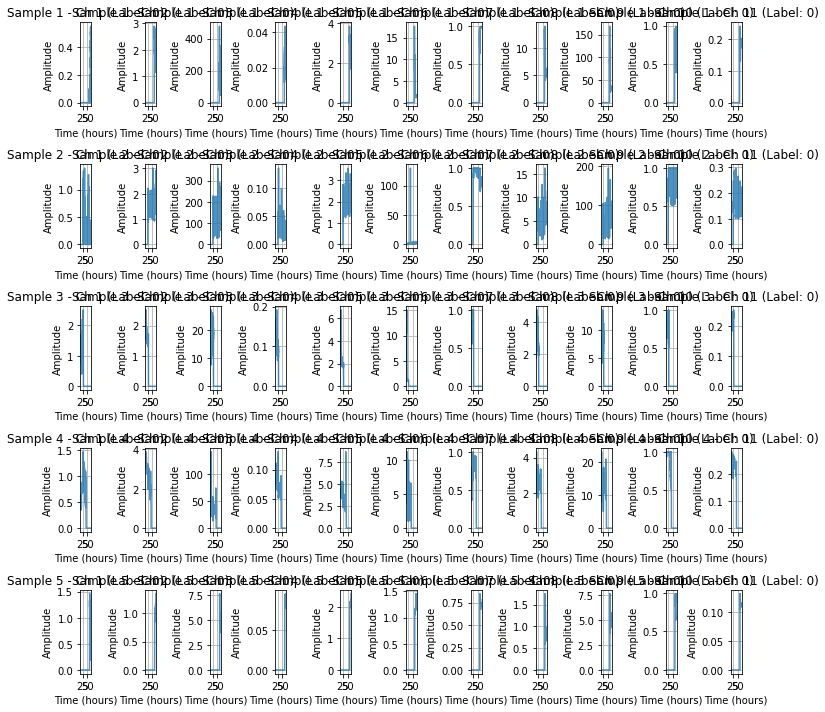

Train set size (before augmentation): 212
Train set label distribution: {0: 177, 1: 35}
Test set size: 54
Test set label distribution: {0: 46, 1: 8}


In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameter settings
latent_dim = 10  # Dimension of the latent space
initial_channels = 128  # Initial number of channels for CNN
start_time=16
seq_length = (68 - start_time) * 12  # Number of `5min` windows for 52 hours (624)
batch_size = 32
epochs = 100
alpha = 1e-6  # Weight for KL loss
patience = 10  # Define the number of epochs without improvement before stopping training
padding_method = 'constant'  # Use constant padding
is_augment = True  # Enable data augmentation
num_good_train=5
num_bad_train=1
num_good_test=5
num_bad_test=1
#column_names=['BCI', 'BSAR', 'SIQ', 'SIQ_alpha', 'SIQ_beta', 'SIQ_delta', 'SIQ_theta', 'SignalSD','Prob Seizure','spike hz']
column_names=['spike hz','meanskewamp', 'deltaalphapct', 'alphameanrat', 'overallskewamp', 'BSAR', 'BCI', 'deltathetamean', 'deltaalphamean', 'Prob GPD', 'pctpeakpoint']

#column_names=['meanlogentropy']


num_eeg_channels=len(column_names)

is_VAEtrain_aug=False

# Define dataset folder paths
data_folder = '5min_smoothed_data/'  # Replace with the actual data folder path
valid_outcome_data = 'valid_patients_outcome.csv'
ssd_file = 'files_art_ssd_fts_predictions.csv'

# Create EEG dataset (labels are not used when training VAE)
eeg_dataset = EEGDataset(
    data_folder='5min_smoothed_data/',
    outcome_file='valid_patients_outcome.csv',
    ssd_file=ssd_file,
    start_time=start_time,
    target_length=seq_length,
    strategy='padding',
    padding_mode=padding_method,
    use_labels=True,  # Use labels to determine class-based augmentation
    augment=False,  # Enable data augmentation
    num_good=1,
    num_bad=1,
    column_names=column_names
)

visualize_augmented_samples(eeg_dataset, num_samples=5)  # Random Visualize 5 sapmle


seed_value = 3  
torch.manual_seed(seed_value)
train_size = int(0.8 * len(eeg_dataset))
test_size = len(eeg_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(eeg_dataset, [train_size, test_size])

print(f"Train set size (before augmentation): {len(train_dataset)}")
print(f"Train set label distribution: {count_labels(train_dataset)}")  
print(f"Test set size: {len(test_dataset)}")
print(f"Test set label distribution: {count_labels(test_dataset)}")  

# Augment the training set and the training set respectively
augmented_train_dataset = AugmentedEEGDataset(train_dataset, eeg_dataset, augment=is_augment, num_good=num_good_train, num_bad=num_bad_train)
augmented_test_dataset = AugmentedEEGDataset(test_dataset, eeg_dataset, augment=is_augment, num_good=num_good_test, num_bad=num_bad_test)

# Create DataLoader
if is_VAEtrain_aug:
    print("\n Augment the training set and the training set respectively:\n")
    aug_labels = [augmented_train_dataset[i][1] for i in range(len(augmented_train_dataset))]
    unique, counts = np.unique(aug_labels, return_counts=True)
    print(f"Train set size (after augmentation): {len(augmented_train_dataset)}")
    print(f"Train set label distribution (after augmentation): {dict(zip(unique, counts))}")



    aug_labels = [augmented_test_dataset[i][1] for i in range(len(augmented_test_dataset))]
    unique, counts = np.unique(aug_labels, return_counts=True)
    print(f"Test set size (after augmentation): {len(augmented_test_dataset)}")
    print(f"Test set label distribution (after augmentation): {dict(zip(unique, counts))}")

    train_loader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(augmented_test_dataset, batch_size=batch_size, shuffle=False)
else:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)